# Supermart Grocery Sales - ML Project

## 🎯 Objective
To build machine learning models that can predict grocery sales with high accuracy using historical data from Supermart.

## Import necessary libraries

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Load dataset

### 📁 Dataset Overview
Total Rows: 9994

Features include: Category, Sales, Profit and other related fields.

Target: Sales

In [2]:
#Load dataset
data = pd.read_csv('Supermart Grocery Sales - Retail Analytics Dataset.csv')

# Display the first few rows of the dataset
print(data.head())

  Order ID Customer Name          Category      Sub Category         City  \
0      OD1        Harish      Oil & Masala           Masalas      Vellore   
1      OD2         Sudha         Beverages     Health Drinks  Krishnagiri   
2      OD3       Hussain       Food Grains      Atta & Flour   Perambalur   
3      OD4       Jackson  Fruits & Veggies  Fresh Vegetables   Dharmapuri   
4      OD5       Ridhesh       Food Grains   Organic Staples         Ooty   

   Order Date Region  Sales  Discount  Profit       State  
0  11-08-2017  North   1254      0.12  401.28  Tamil Nadu  
1  11-08-2017  South    749      0.18  149.80  Tamil Nadu  
2  06-12-2017   West   2360      0.21  165.20  Tamil Nadu  
3  10-11-2016  South    896      0.25   89.60  Tamil Nadu  
4  10-11-2016  South   2355      0.26  918.45  Tamil Nadu  


## 🧹 Data Preprocessing

In [3]:
#Check for missing values
print(data.isnull().sum())

# Drop any rows with missing values
data.dropna(inplace=True)

# Check for duplicates
data.drop_duplicates(inplace=True)

Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64


In [4]:
#Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')

data.dropna(subset=['Order Date'], inplace=True)

# Extract day, month, and year from 'Order Date'
data['Order Day'] = data['Order Date'].dt.day
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year

In [5]:
#Initialize the label encoder
le = LabelEncoder()

# Encode categorical variables
categorical_cols = ['Category', 'Sub Category', 'City', 'Region', 'State']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Display the first few rows after encoding
print(data.head())

  Order ID Customer Name  Category  Sub Category  City Order Date  Region  \
0      OD1        Harish         5            14    21 2017-11-08       2   
1      OD2         Sudha         1            13     8 2017-11-08       3   
2      OD3       Hussain         3             0    13 2017-06-12       4   
3      OD4       Jackson         4            12     4 2016-10-11       3   
4      OD5       Ridhesh         3            18    12 2016-10-11       3   

   Sales  Discount  Profit  State  Order Day  Order Month  Order Year  
0   1254      0.12  401.28      0          8           11        2017  
1    749      0.18  149.80      0          8           11        2017  
2   2360      0.21  165.20      0         12            6        2017  
3    896      0.25   89.60      0         11           10        2016  
4   2355      0.26  918.45      0         11           10        2016  


## Exploratory Data Analysis (EDA)

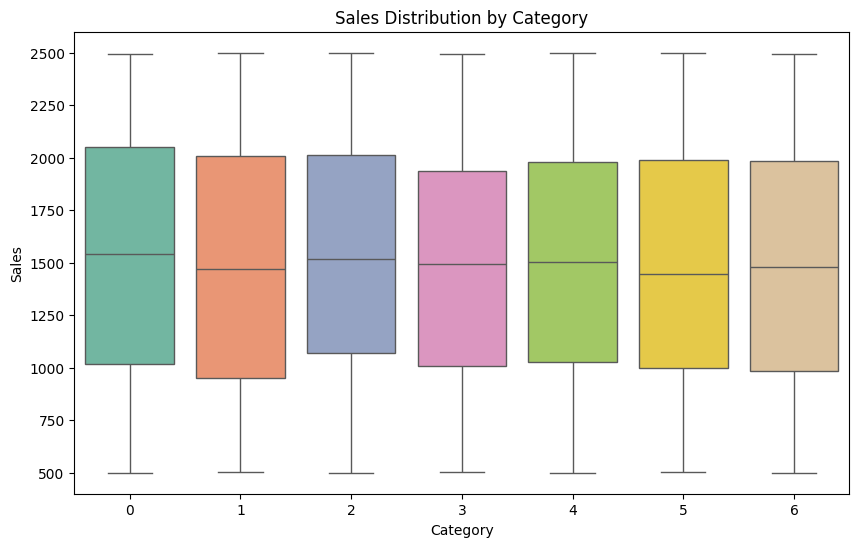

In [6]:
# Distribution of Sales by Category

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Sales', data=data, palette='Set2',hue=data['Category'] , legend=False)
plt.title('Sales Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.show()

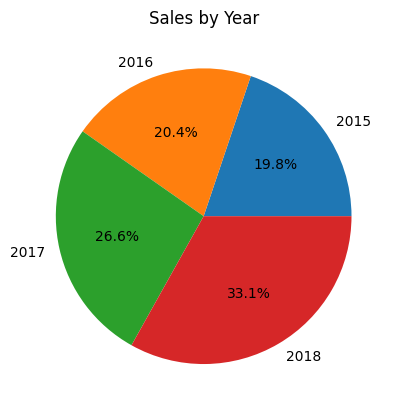

In [7]:
# Create a pie chart with the sales by year

Yearly_Sales=data.groupby("Order Year")["Sales"].sum()

plt.pie(Yearly_Sales, labels=Yearly_Sales.index,autopct='%1.1f%%')
plt.title('Sales by Year')
plt.show()

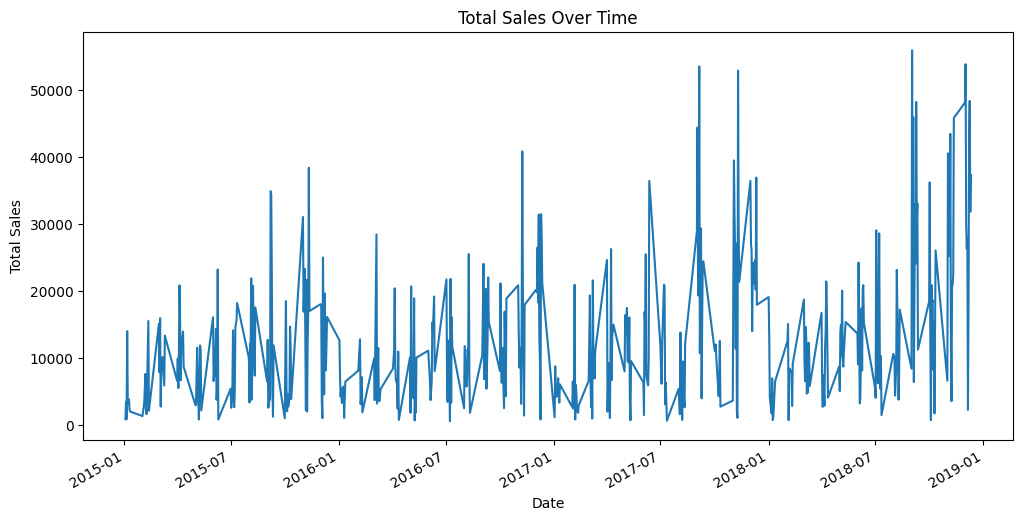

In [8]:
# Sales Trends Over Time

plt.figure(figsize=(12, 6))
data.groupby('Order Date')['Sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

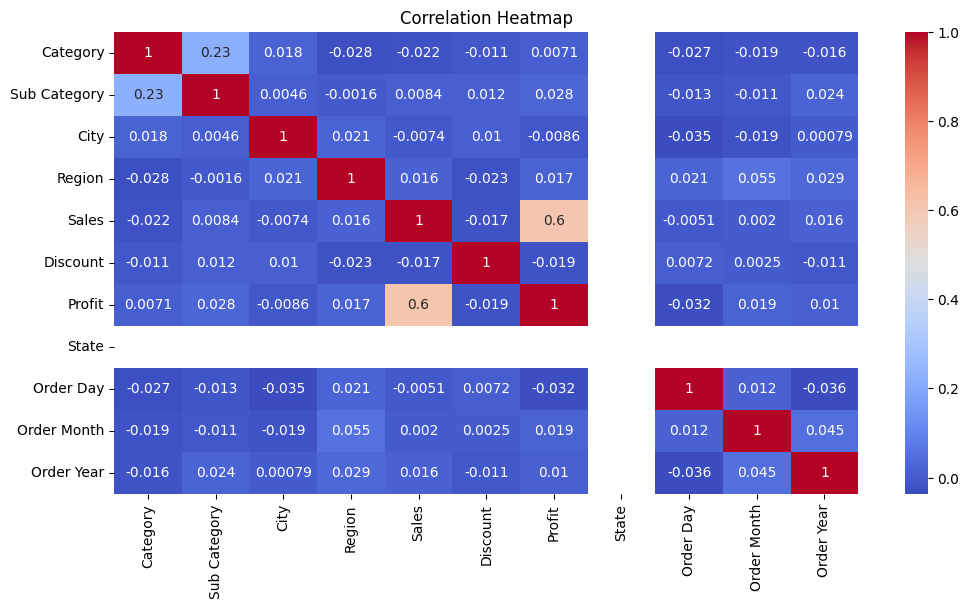

In [9]:
#Correlation Matrix

plt.figure(figsize=(12, 6))
corr_matrix = data.drop(columns=['Order ID']).corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

In [10]:
# Feature Engineering
data['Total Discount'] = data['Discount'] * data['Sales']
data['Profit Margin'] = data['Profit'] / (data['Sales'] + 1e-5)

In [11]:
data.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Order Day,Order Month,Order Year,Total Discount,Profit Margin
0,OD1,Harish,5,14,21,2017-11-08,2,1254,0.12,401.28,0,8,11,2017,150.48,0.32
1,OD2,Sudha,1,13,8,2017-11-08,3,749,0.18,149.80,0,8,11,2017,134.82,0.20
2,OD3,Hussain,3,0,13,2017-06-12,4,2360,0.21,165.20,0,12,6,2017,495.60,0.07
3,OD4,Jackson,4,12,4,2016-10-11,3,896,0.25,89.60,0,11,10,2016,224.00,0.10
4,OD5,Ridhesh,3,18,12,2016-10-11,3,2355,0.26,918.45,0,11,10,2016,612.30,0.39


## Feature Selection

In [12]:
# Select features and target variable
X = data.drop(columns=['Order ID', 'Customer Name','Order Date', 'Sales'])
y = data['Sales']

# Drop rows with NaN values
X.dropna(inplace=True)
y = y[X.index] # Align y with the filtered X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 🤖 Model Training and Testing

The following models were trained & tested:

Linear Regression

Random Forest Regressor

XGBoost Regressor

In [13]:
# Initialize the model

model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split= 2, min_samples_leaf= 2, max_depth=None)
xgb_model = XGBRegressor(n_estimators= 500, subsample= 0.7, reg_lambda= 0.5, reg_alpha= 1, max_depth= 6, learning_rate= 0.05, gamma= 0.2, colsample_bytree= 1.0, random_state=42)

# Train the model

model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions

ln_train_preds = model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)

ln_preds = model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

In [14]:
def outliers(y_preds, model_name="Model"):
  Q1 = np.percentile(y_preds, 25)
  Q3 = np.percentile(y_preds, 75)
  IQR = Q3 - Q1
  LB = Q1 - 1.5 * IQR
  UB = Q3 + 1.5 * IQR
  outlier_values = y_preds[(y_preds < LB) | (y_preds > UB)]
  print(f"[{model_name}] → {len(outlier_values)} outliers found")
  print(outlier_values)
  return outlier_values

outliers(ln_preds, model_name="Linear Regression")
outliers(rf_preds, model_name="Random Forest")
outliers(xgb_preds, model_name="XGBoost")

[Linear Regression] → 0 outliers found
[]
[Random Forest] → 0 outliers found
[]
[XGBoost] → 0 outliers found
[]


array([], dtype=float32)

## Model Evaluation

In [15]:
# Step 9: Evaluation Function
def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae_ = mean_absolute_error(y_true,y_pred)
    print(f"{name} = MSE: {mse:.2f} , R²: {r2:.4f}, MAE: {mae_:.2f}")

print("Training Performance:")
evaluate("Linear Regression -> Train", y_train, ln_train_preds)
evaluate("Random Forest     -> Train", y_train, rf_train_preds)
evaluate("XGBoost           -> Train", y_train, xgb_train_preds)
print("Testing Performance:")
evaluate("Linear Regression -> Test", y_test, ln_preds)
evaluate("Random Forest     -> Test", y_test, rf_preds)
evaluate("XGBoost           -> Test", y_test, xgb_preds)

Training Performance:
Linear Regression -> Train = MSE: 22781.07 , R²: 0.9306, MAE: 105.88
Random Forest     -> Train = MSE: 102.74 , R²: 0.9997, MAE: 6.90
XGBoost           -> Train = MSE: 20.75 , R²: 0.9999, MAE: 3.51
Testing Performance:
Linear Regression -> Test = MSE: 22058.99 , R²: 0.9341, MAE: 106.54
Random Forest     -> Test = MSE: 463.46 , R²: 0.9986, MAE: 14.71
XGBoost           -> Test = MSE: 363.12 , R²: 0.9989, MAE: 13.34


In [16]:
data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train R²': [0.9306, 0.9997, 0.9999],
    'Test R²': [0.9341, 0.9986, 0.9989],
    'Train MSE': [22781.07, 102.74, 20.75],
    'Test MSE': [22058.99, 463.46, 363.12],
    'Train MAE': [105.88, 6.90, 3.51],
    'Test MAE': [106.54, 14.71, 13.34]
}

df = pd.DataFrame(data)
print(df)

               Model  Train R²  Test R²  Train MSE  Test MSE  Train MAE  \
0  Linear Regression    0.9306   0.9341   22781.07  22058.99     105.88   
1      Random Forest    0.9997   0.9986     102.74    463.46       6.90   
2            XGBoost    0.9999   0.9989      20.75    363.12       3.51   

   Test MAE  
0    106.54  
1     14.71  
2     13.34  


In [17]:
index = np.arange(len(df['Model']))

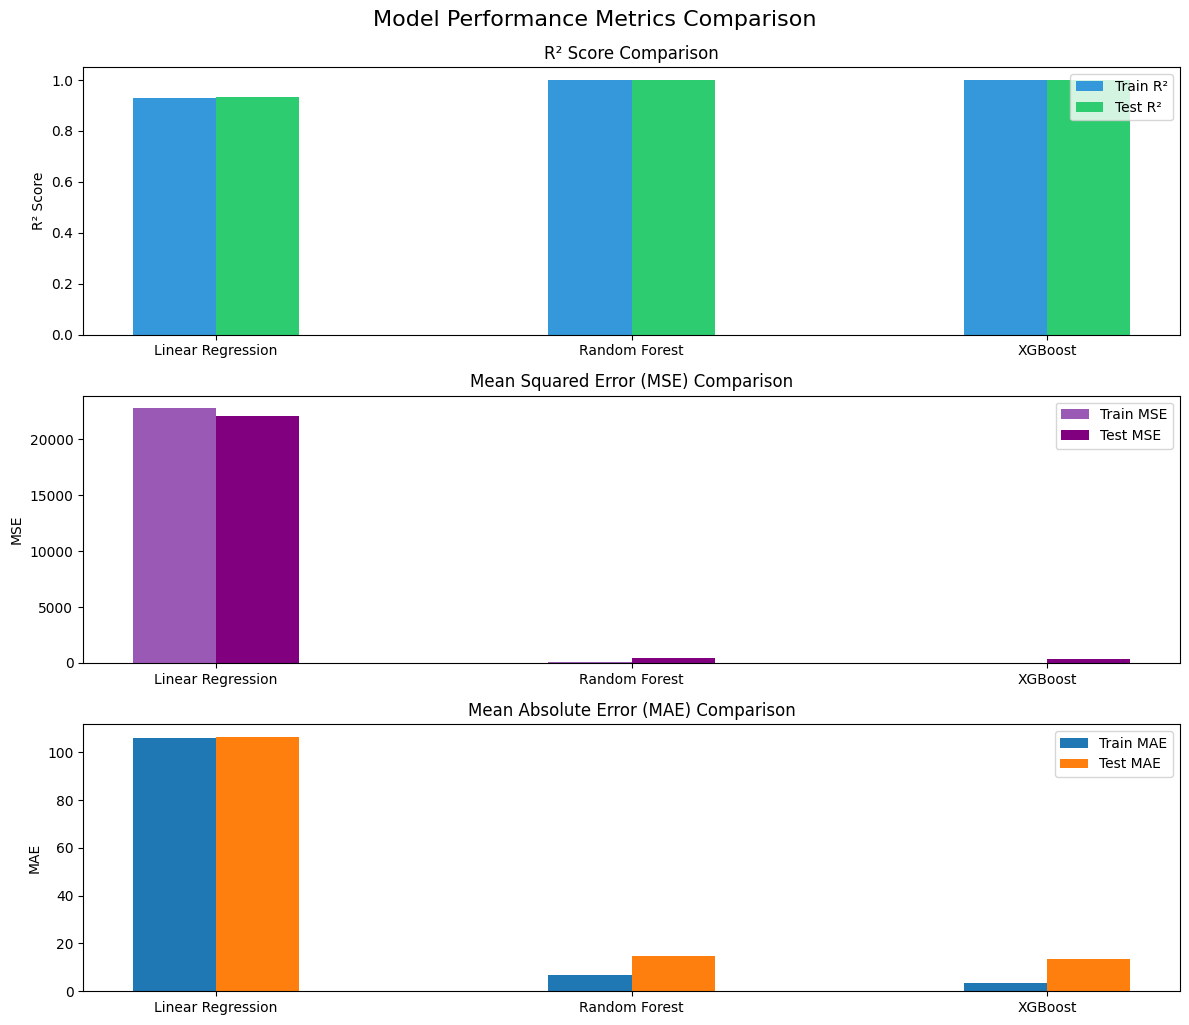

In [18]:
# Plotting
plt.figure(figsize=(12, 10))

# R² Score
plt.subplot(3, 1, 1)
plt.bar(index, df['Train R²'], width=0.2, label='Train R²', color='#3498db')
plt.bar(index + 0.2, df['Test R²'], width=0.2, label='Test R²', color='#2ecc71')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.legend()

# MSE
plt.subplot(3, 1, 2)
plt.bar(index, df['Train MSE'], width=0.2, label='Train MSE', color='#9b59b6')
plt.bar(index + 0.2, df['Test MSE'], width=0.2, label='Test MSE',color='purple')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.legend()

# MAE
plt.subplot(3, 1, 3)
plt.bar(index, df['Train MAE'], width=0.2, label='Train MAE')
plt.bar(index + 0.2, df['Test MAE'], width=0.2, label='Test MAE')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance Metrics Comparison', fontsize=16, y=1.02)
plt.show()


In [19]:
# Cross Validation

def evaluate_cv(model, X, y, model_name="Model", cv=5, scoring='r2'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f"{model_name} - CV R² Scores: {scores}")
    print(f"{model_name} - Mean CV R²  : {scores.mean():.4f}")
    return scores

evaluate_cv(model, X_train, y_train, model_name="Linear Regression")
evaluate_cv(rf_model, X_train, y_train, model_name="Random Forest")
evaluate_cv(xgb_model, X_train, y_train, model_name="XGBoost")

Linear Regression - CV R² Scores: [0.93283838 0.93027737 0.92726706 0.92920204 0.93048691]
Linear Regression - Mean CV R²  : 0.9300
Random Forest - CV R² Scores: [0.99732764 0.99751849 0.99800289 0.99820728 0.99770624]
Random Forest - Mean CV R²  : 0.9978
XGBoost - CV R² Scores: [0.99871868 0.99870157 0.99890596 0.99888659 0.99876243]
XGBoost - Mean CV R²  : 0.9988


array([0.99871868, 0.99870157, 0.99890596, 0.99888659, 0.99876243])

## Result

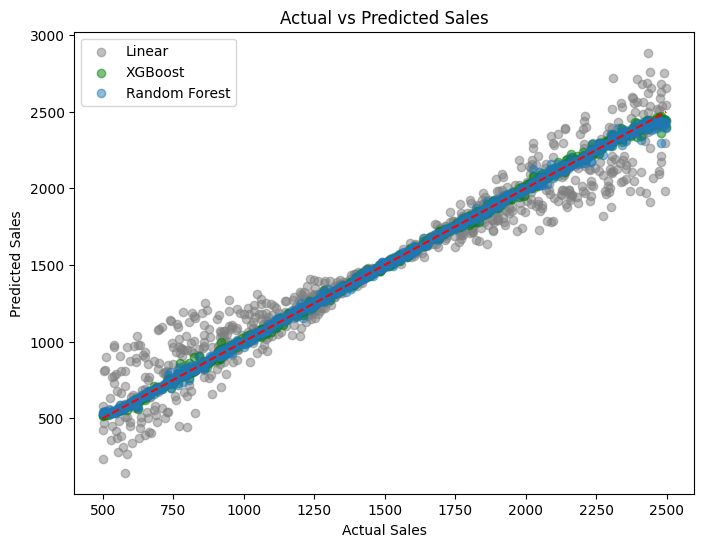

In [20]:
#Plot Actual vs Predicted Sales
plt.figure(figsize=(8,6))
plt.scatter(y_test, ln_preds, alpha=0.5, label='Linear', color='gray')
plt.scatter(y_test, xgb_preds, alpha=0.5, label='XGBoost', color='green')
plt.scatter(y_test, rf_preds, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()

## ✅ Conclusion
Linear Regression performs reasonably well but has higher error.

Random Forest and XGBoost outperform Linear Regression significantly.

XGBoost is the best performing model with the lowest test MSE and highest R² score.

Recommendation: Use XGBoost for final deployment in predicting sales